# Backtesting the HMM Model

Signals are identifed by the hmm model and imported into the system. 

    When signal = 1, we enter the mean reversion position.    
    When signal = 0, we enter the momentum position. 


Mean Reversion Strategy:
     
     1.We rank the returns of ETF stocks in the past month
     2.For bottom 3 stock, we buy     
     3.For top 3 stocks, we sell     
     4.We close the position every 10 days 


Momentum Strategy: 

     1.We rank the returns of ETF stocks in the past 6 months
     2.For bottom 3 stock, we buy     
     3.For top 3 stocks, we sell     
     4.We close the position every month 
    
    
    


In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
from datetime import datetime

In [22]:

class RSI_Oversold(bt.Indicator):
    lines = ('oversold',)
    
    params = (
        ('level', 30),    
    )

    def __init__(self):
        self.lines.oversold = bt.indicators.RSI(self.data) < self.p.level

        
class DummyInd(bt.Indicator):
    lines = ('dummyline',)

    params = (('value', 5),)

    def __init__(self):
        self.lines.dummyline = bt.Max(0.0, self.params.value)

        
# Create a Stratey
class BackTradingStrategy(bt.Strategy):
    params = (
        ('period', 255),
        ("max_days_in_trade", 10)
    )

    def log(self, txt, txt2, txt3, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s, %s, %s' % (dt.isoformat(), txt, txt2, txt3))
        
        
    def read_signals(self):
        signal_data = pd.read_csv("hmm_regime_signals.csv")
        signal_data["datetime"] = signal_data["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))
        signal_data = signal_data.set_index('datetime')
        
        return signal_data
        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        # How to access individual etf
        self.xlb_close = self.datas[symbols.index("XLB")].close
        self.xle_close = self.datas[symbols.index("XLE")].close
        self.xlf_close = self.datas[symbols.index("XLF")].close
        self.xli_close = self.datas[symbols.index("XLI")].close
        self.xlk_close = self.datas[symbols.index("XLK")].close
        self.xlp_close = self.datas[symbols.index("XLP")].close
        self.xlu_close = self.datas[symbols.index("XLU")].close
        self.xlv_close = self.datas[symbols.index("XLV")].close
        self.xly_close = self.datas[symbols.index("XLY")].close
        
        self.datadate = self.datas[0].datetime.date
        self.days_in_trade = 0
        self.max_days_in_trade_mr = 10
        self.max_days_in_trade_mo = 21
        self.num_mr = 21
        self.num_mo = 21*6
        self.num_mos = [21*6, 21*8, 21*10, 21*12]
        self.regime_state = 0
        self.mrr = 0.02
        self.mor = 0.05
        self.snum = 3        
        self.signal_data = self.read_signals()
        # keep this 
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)        
        self.symbols = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
        self.regimes = ['momentum', 'mean reversion']
        
        
    def stock_return(self, n):
        """calculate return in the past n days """        
        r_xlb = (self.xlb_close[0] - self.xlb_close[-n])/self.xlb_close[-n]
        r_xle = (self.xle_close[0] - self.xle_close[-n])/self.xle_close[-n]
        r_xlf = (self.xlf_close[0] - self.xlf_close[-n])/self.xlf_close[-n]
        r_xli = (self.xli_close[0] - self.xli_close[-n])/self.xli_close[-n]
        r_xlk = (self.xlk_close[0] - self.xlk_close[-n])/self.xlk_close[-n]
        r_xlp = (self.xlp_close[0] - self.xlp_close[-n])/self.xlp_close[-n]
        r_xlu = (self.xlu_close[0] - self.xlu_close[-n])/self.xlu_close[-n]
        r_xlv = (self.xlv_close[0] - self.xlv_close[-n])/self.xlv_close[-n]
        r_xly = (self.xly_close[0] - self.xly_close[-n])/self.xly_close[-n]
        r_list = [r_xlb, r_xle, r_xlf, r_xli, r_xlk, r_xlp, r_xlu, r_xlv, r_xly]        
        
        df = pd.DataFrame(r_list, index = self.symbols, columns = ['return'])
        
        return df
    
    
    
    def sort_return(self, n):
        """sort return in the past n days in ascending order 
           return the bottom and top 3 return stocks """
        
        df = self.stock_return(n)
        df = df.sort_values(by=['return'])                
        stock_list = [df.index[0:3].tolist(),df.index[6:].tolist()]
        
        return stock_list
    
    
    def sort_return2(self, num_mos):
        """sort return in the past n days in ascending order 
        return the bottom and top 3 return stocks """
        n = len(num_mos)
        snum = len(symbols)
        scores=[0]*snum
        print('scores = ', scores)
        for i in range(n):
            s = []
            df = self.stock_return(num_mos[i])
            df = df.sort_values(by=['return'])
            print('df =', df)
            sorted_index = df.index.tolist()
            dictionary = self.list_to_dict(sorted_index)
            for symbol in symbols:
                s.append(dictionary[symbol])
            print('s =', s)
            print('symbols = ', symbols)
            for j in range(snum):
                scores[j] = scores[j] + s[j]
            print('scores = ', scores)
        ddf = pd.DataFrame(scores, index = symbols, columns=['return'])
        print(ddf)
        ddf = ddf.sort_values(by=['return'])
        print('ddf = ', ddf)
        stock_list = [ddf.index[0:3].tolist(),ddf.index[6:].tolist()]
        return stock_list
        
        
    
    def list_to_dict(self,llist):  
        dct = {} 
        n = len(llist)
        for i in range(n):
            item = llist[i]
            dct[item] = i  
        return dct 

    
    def check_position(self):
        flag = False
        names = []
        for symbol in self.symbols:
            s_size = self.getposition(data=self.datas[symbols.index(symbol)]).size
            if  s_size != 0:
                flag = True
                names.append(symbol)
        return flag, names
            
                
    

    def next(self):
        # Simply log the closing price of the series from the reference               
        
        dt = self.datadate(0).strftime('%Y-%m-%d')
        
        signal = self.signal_data['state'].loc[dt]
        
        position, names = self.check_position()
        
        self.log('regime = %s' % self.regimes[signal], '      HAS Position at %s' % " ".join(names[:3]), ' and  at  %s' %  " ".join(names[3:]))

        
        
        # Check if we are in the market
        if not position:
            # if we do not have a position
            
            if signal == 1:
                """mean reversion"""
                
                stock_list = self.sort_return(self.num_mr)
                # print('stocklist = ', stock_list)
                
                self.log('regime = %s' % self.regimes[signal], 'CREATE BUY  for %s' % " ".join(stock_list[0]), ' SELL for %s' %  " ".join(stock_list[0])) 

                # Buy bottom snum stocks
                for i in range(self.snum):
                    self.order = self.buy(data = self.datas[symbols.index(stock_list[0][i])])
                    
                # Sell top snum stocks    
                for i in range(self.snum):
                    self.order = self.sell(data = self.datas[symbols.index(stock_list[1][i])])

                self.days_in_trade = 1
                
                self.regime_state = 1
                    
                    
         
            
            else:
                """momentum"""  
                
                stock_list = self.sort_return2(self.num_mos)
                print('stocklist = ', stock_list)
                
                self.log('regime = %s' % self.regimes[signal], '      CREATE SELL for %s' % " ".join(stock_list[0]), ' BUY  for %s' %  " ".join(stock_list[0]))

                # Sell bottom snum stocks
                for i in range(self.snum):
                    self.order = self.sell(data = self.datas[symbols.index(stock_list[0][i])])
                    
                # Buy top snum stocks    
                for i in range(self.snum):
                    self.order = self.buy(data = self.datas[symbols.index(stock_list[1][i])])
                    
                self.days_in_trade = 1
                
                self.regime_state = 0
                    
            
                
            

        else:
            # if we have a position
            
            self.days_in_trade += 1
            
            """mean reversion"""
            if (self.regime_state == 1):
            
                # close the position if regime shift or after holding it for max_mr days.
                if signal == 0 or self.days_in_trade == self.max_days_in_trade_mr:
                    num = len(names)
                    for i in range(num):
                        self.close(data=self.datas[symbols.index(names[i])])
                    
                    self.log('regime = %s' % self.regimes[signal], 'CLOSE Position  %s' % " ".join(names[:3]), ' and for  %s' %  " ".join(names[3:]))
                    self.days_in_trade = 0                    
                    self.regime_state = 0 
                    
            
            """momentum"""
            if (self.regime_state == 0):
                
                # close the position if regime shift or after holding it for max_mo days.
                if signal == 1 or self.days_in_trade == self.max_days_in_trade_mo:
                    num = len(names)
                    for i in range(num):
                        self.close(data=self.datas[symbols.index(names[i])])
                    
                    self.log('regime = %s' % self.regimes[signal], '      CLOSE Position  %s' % " ".join(names[:3]), ' and for  %s' %  " ".join(names[3:]))
                    self.days_in_trade = 0                        
                    self.regime_state = 1
                 
       


In [23]:


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()   

    symbols = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
    for symbol in symbols:
        datapath = os.path.join('../../../datas/%s.csv' % symbol)

        # Create a Data Feed
        data = bt.feeds.YahooFinanceCSVData(
            dataname=datapath,
            # Do not pass values before this date
            fromdate=datetime(2013, 2, 11),
            # Do not pass values before this date
            todate=datetime(2018, 2, 9),
            # Do not pass values after this date
            reverse=False)

        # Add the Data Feed to Cerebro
        cerebro.adddata(data, name=symbol)


    # Add a strategy
    cerebro.addstrategy(BackTradingStrategy) #, symbols= symbols)
    
    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    

    # Write output
    cerebro.addwriter(bt.WriterFile, out='0402-ETFbacktesting.csv',csv=True)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2014-02-13, regime = momentum,       HAS Position at ,  and  at  
scores =  [0, 0, 0, 0, 0, 0, 0, 0, 0]
df =        return
XLP  0.024284
XLE  0.045118
XLU  0.061473
XLF  0.070759
XLY  0.099316
XLB  0.118254
XLK  0.122784
XLI  0.134314
XLV  0.158118
s = [5, 1, 3, 7, 6, 0, 2, 8, 4]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [5, 1, 3, 7, 6, 0, 2, 8, 4]
df =        return
XLP  0.043357
XLE  0.077630
XLU  0.085590
XLF  0.119430
XLY  0.161376
XLK  0.164065
XLB  0.164142
XLI  0.196338
XLV  0.210188
s = [6, 1, 3, 7, 5, 0, 2, 8, 4]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [11, 2, 6, 14, 11, 0, 4, 16, 8]
df =        return
XLU  0.025581
XLP  0.040466
XLE  0.136954
XLF  0.191651
XLK  0.208063
XLY  0.217859
XLB  0.227352
XLV  0.230354
XLI  0.262141
s = [6, 2, 3, 8, 4, 1, 0, 7, 5]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [17, 4, 9, 22,

2014-07-03, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-07, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-08, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-09, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-10, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-11, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-14, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-15, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLP XLY
2014-07-15, regime = momentum,       CLOSE Position  XLB XLE XLF,  and for  XLI XLP XLY
2014-07-16, regime = momentum,       HAS Position at ,  and  at  
scores =  [0, 0, 0, 0, 0, 0, 0, 0, 0]
df =        return
XLY  0.036384
XLF  0.056604
XLI  0.063416
XLP  0.075314
XLV  0.079717
XLB  0.101233
X

2014-09-17, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-18, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-19, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-22, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-23, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-24, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-25, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-26, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-29, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-09-30, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-10-01, regime = momentum,       HAS Position at XLB XLI XLK,  and  at  XLP XLV XLY
2014-10-02, regime = momentum,  

2014-12-02, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-03, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-04, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-05, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-08, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-09, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-10, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-11, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-12, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-15, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-16, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLV
2014-12-17, regime = momentum,  

2015-02-18, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-02-19, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-02-20, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-02-23, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-02-24, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-02-25, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-02-26, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-02-27, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-03-02, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-03-03, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-03-04, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLV
2015-03-05, regime = momentum,  

ddf =       return
XLE       0
XLU       5
XLI      10
XLB      12
XLF      16
XLP      19
XLK      22
XLY      29
XLV      31
stocklist =  [['XLE', 'XLU', 'XLI'], ['XLK', 'XLY', 'XLV']]
2015-05-11, regime = momentum,       CREATE SELL for XLE XLU XLI,  BUY  for XLE XLU XLI
2015-05-12, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-13, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-14, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-15, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-18, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-19, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-20, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-21, regime = momentum,       HAS Position at XLE XLI XLK,  and  at  XLU XLV XLY
2015-05-22, regime = 

2015-08-07, regime = momentum,       HAS Position at XLB XLE XLP,  and  at  XLU XLV XLY
2015-08-07, regime = momentum,       CLOSE Position  XLB XLE XLP,  and for  XLU XLV XLY
2015-08-10, regime = momentum,       HAS Position at ,  and  at  
scores =  [0, 0, 0, 0, 0, 0, 0, 0, 0]
df =        return
XLE -0.122508
XLB -0.063019
XLU -0.025696
XLI -0.014052
XLP  0.046816
XLK  0.051578
XLF  0.067606
XLY  0.093552
XLV  0.107706
s = [1, 0, 6, 3, 5, 4, 2, 8, 7]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [1, 0, 6, 3, 5, 4, 2, 8, 7]
df =        return
XLE -0.084236
XLB -0.040340
XLU -0.018863
XLI -0.018711
XLF  0.033401
XLK  0.040366
XLP  0.053125
XLV  0.079379
XLY  0.124464
s = [1, 0, 4, 3, 5, 6, 2, 7, 8]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [2, 0, 10, 6, 10, 10, 4, 15, 15]
df =        return
XLE -0.198078
XLB -0.024817
XLU  0.044273
XLI  0.063063
XLK  0.092217
XLF  0.108998
XLP  0.119867
XLV  0.185005
XLY 

2015-10-14, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLY
2015-10-15, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLY
2015-10-16, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLY
2015-10-19, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLY
2015-10-20, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLY
2015-10-21, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLY
2015-10-22, regime = mean reversion,       HAS Position at XLB XLE XLI,  and  at  XLP XLU XLY
2015-10-22, regime = mean reversion,       CLOSE Position  XLB XLE XLI,  and for  XLP XLU XLY
2015-10-23, regime = mean reversion,       HAS Position at ,  and  at  
2015-10-23, regime = mean reversion, CREATE BUY  for XLV XLU XLY,  SELL for XLV XLU XLY
2015-10-26, regime = mean reversion,       HAS Position at XLB XLI XLK,  and  at  XLU XLV XLY
2015-10-27, regime = mean reve

XLY  0.097086
s = [1, 0, 4, 3, 7, 6, 2, 5, 8]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [3, 0, 13, 8, 20, 20, 10, 11, 23]
df =        return
XLE -0.144915
XLU -0.054094
XLB -0.042416
XLI -0.016952
XLF -0.005540
XLV  0.038293
XLP  0.066697
XLK  0.084580
XLY  0.159730
s = [2, 0, 4, 3, 7, 6, 1, 5, 8]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [5, 0, 17, 11, 27, 26, 11, 16, 31]
     return
XLB       5
XLE       0
XLF      17
XLI      11
XLK      27
XLP      26
XLU      11
XLV      16
XLY      31
ddf =       return
XLE       0
XLB       5
XLI      11
XLU      11
XLV      16
XLF      17
XLP      26
XLK      27
XLY      31
stocklist =  [['XLE', 'XLB', 'XLI'], ['XLP', 'XLK', 'XLY']]
2015-12-10, regime = momentum,       CREATE SELL for XLE XLB XLI,  BUY  for XLE XLB XLI
2015-12-11, regime = momentum,       HAS Position at XLB XLE XLI,  and  at  XLK XLP XLY
2015-12-14, regime = momentum,       HAS Position at XL

2016-02-26, regime = mean reversion,       CLOSE Position  XLB XLE XLF,  and for  XLK XLP XLU
2016-02-29, regime = mean reversion,       HAS Position at ,  and  at  
2016-02-29, regime = mean reversion, CREATE BUY  for XLF XLE XLV,  SELL for XLF XLE XLV
2016-03-01, regime = mean reversion,       HAS Position at XLB XLE XLF,  and  at  XLI XLU XLV
2016-03-02, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLI XLU XLV
2016-03-02, regime = momentum, CLOSE Position  XLB XLE XLF,  and for  XLI XLU XLV
2016-03-03, regime = momentum,       HAS Position at ,  and  at  
scores =  [0, 0, 0, 0, 0, 0, 0, 0, 0]
df =        return
XLE -0.042339
XLF -0.010363
XLV -0.007876
XLB  0.035303
XLY  0.059141
XLI  0.085093
XLK  0.096783
XLP  0.133809
XLU  0.150092
s = [3, 0, 1, 5, 6, 7, 8, 2, 4]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [3, 0, 1, 5, 6, 7, 8, 2, 4]
df =        return
XLE -0.175943
XLB -0.102842
XLV -0.090404
XLF -0.089237
XLI -0.000972

2016-05-05, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-06, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-09, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-10, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-11, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-12, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-13, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-16, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-17, regime = momentum,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-18, regime = mean reversion,       HAS Position at XLE XLF XLK,  and  at  XLP XLU XLV
2016-05-18, regime = mean reversion,       CLOSE Position  XLE XLF XLK,  and for  XLP XLU XLV
2016-05-19, regime =

2016-07-13, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-14, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-15, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-18, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-19, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-20, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-21, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-22, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-25, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-26, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-27, regime = momentum,       HAS Position at XLF XLI XLP,  and  at  XLU XLV XLY
2016-07-28, regime = momentum,  

2016-09-23, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-09-26, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-09-27, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-09-28, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-09-29, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-09-30, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-10-03, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-10-04, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-10-05, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-10-06, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-10-07, regime = momentum,       HAS Position at XLF XLK XLP,  and  at  XLU XLV XLY
2016-10-10, regime = momentum,  

df =        return
XLU  0.030978
XLP  0.037964
XLV  0.072561
XLY  0.187041
XLK  0.210209
XLB  0.257099
XLI  0.274526
XLE  0.376444
XLF  0.778922
s = [5, 7, 8, 6, 4, 1, 0, 2, 3]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [14, 20, 24, 19, 13, 3, 2, 4, 9]
df =        return
XLV -0.033627
XLP  0.028800
XLY  0.029565
XLK  0.078125
XLB  0.122687
XLU  0.142095
XLI  0.176052
XLE  0.200892
XLF  0.512803
s = [4, 7, 8, 6, 3, 1, 5, 0, 2]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [18, 27, 32, 25, 16, 4, 7, 4, 11]
     return
XLB      18
XLE      27
XLF      32
XLI      25
XLK      16
XLP       4
XLU       7
XLV       4
XLY      11
ddf =       return
XLP       4
XLV       4
XLU       7
XLY      11
XLK      16
XLB      18
XLI      25
XLE      27
XLF      32
stocklist =  [['XLP', 'XLV', 'XLU'], ['XLI', 'XLE', 'XLF']]
2016-12-05, regime = momentum,       CREATE SELL for XLP XLV XLU,  BUY  for XLP XLV XLU
2016-12-06, re

df =        return
XLU -0.002081
XLP  0.027453
XLV  0.058746
XLE  0.094189
XLY  0.118666
XLB  0.124427
XLI  0.194115
XLK  0.218601
XLF  0.749273
s = [5, 3, 8, 6, 7, 1, 0, 2, 4]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [10, 6, 16, 13, 13, 2, 2, 2, 8]
df =        return
XLU  0.034520
XLP  0.036739
XLV  0.050000
XLY  0.096218
XLE  0.118295
XLB  0.129358
XLI  0.184254
XLK  0.190565
XLF  0.702263
s = [5, 4, 8, 6, 7, 1, 0, 2, 3]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [15, 10, 24, 19, 20, 3, 2, 4, 11]
df =        return
XLP  0.094359
XLU  0.101539
XLV  0.132385
XLY  0.211027
XLB  0.298135
XLE  0.303013
XLK  0.303894
XLI  0.308129
XLF  0.904272
s = [4, 5, 8, 7, 6, 0, 1, 2, 3]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [19, 15, 32, 26, 26, 3, 3, 6, 14]
     return
XLB      19
XLE      15
XLF      32
XLI      26
XLK      26
XLP       3
XLU       3
XLV       6
XLY   

2017-04-27, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-04-28, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-01, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-02, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-03, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-04, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-05, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-08, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-09, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-10, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-11, regime = momentum,       HAS Position at XLE XLF XLI,  and  at  XLK XLP XLV
2017-05-12, regime = momentum,  

2017-07-13, regime = momentum,       HAS Position at ,  and  at  
scores =  [0, 0, 0, 0, 0, 0, 0, 0, 0]
df =        return
XLE -0.120949
XLP  0.066946
XLF  0.069397
XLY  0.080218
XLU  0.081507
XLB  0.085162
XLI  0.103337
XLV  0.132979
XLK  0.144640
s = [5, 0, 2, 6, 8, 1, 4, 7, 3]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [5, 0, 2, 6, 8, 1, 4, 7, 3]
df =        return
XLE -0.060298
XLP  0.065884
XLU  0.119383
XLV  0.138040
XLY  0.152000
XLB  0.155692
XLI  0.176349
XLK  0.205040
XLF  0.215581
s = [5, 0, 8, 6, 7, 1, 2, 3, 4]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [10, 0, 10, 12, 15, 2, 6, 10, 7]
df =        return
XLE -0.053882
XLP  0.038394
XLU  0.084044
XLV  0.114120
XLY  0.148296
XLB  0.170611
XLI  0.219964
XLK  0.220816
XLF  0.677485
s = [5, 0, 8, 6, 7, 1, 2, 3, 4]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [15, 0, 18, 18, 22, 3, 8, 13, 11]
df =        ret

2017-09-28, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-09-29, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-02, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-03, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-04, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-05, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-06, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-09, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-10, regime = momentum,       HAS Position at XLB XLE XLK,  and  at  XLP XLV XLY
2017-10-10, regime = momentum,       CLOSE Position  XLB XLE XLK,  and for  XLP XLV XLY
2017-10-11, regime = momentum,       HAS Position at ,  and  at  
scores =  [0, 0, 0, 0, 0, 0, 0, 0, 0]
df =        retu

2017-11-30, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLY
2017-12-01, regime = momentum,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLY
2017-12-04, regime = mean reversion,       HAS Position at XLB XLE XLF,  and  at  XLK XLP XLY
2017-12-04, regime = mean reversion,       CLOSE Position  XLB XLE XLF,  and for  XLK XLP XLY
2017-12-05, regime = momentum,       HAS Position at ,  and  at  
scores =  [0, 0, 0, 0, 0, 0, 0, 0, 0]
df =        return
XLP  0.004467
XLU  0.038614
XLY  0.070647
XLV  0.071794
XLE  0.087622
XLK  0.098994
XLI  0.101279
XLB  0.115327
XLF  0.191233
s = [7, 4, 8, 6, 5, 0, 1, 3, 2]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
scores =  [7, 4, 8, 6, 5, 0, 1, 3, 2]
df =        return
XLE  0.001599
XLP  0.052622
XLU  0.089772
XLV  0.114274
XLY  0.117600
XLB  0.139414
XLI  0.141476
XLK  0.186512
XLF  0.188679
s = [5, 0, 8, 6, 7, 1, 2, 3, 4]
symbols =  ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV

In [35]:
# calculate pnl using excel data
import pandas as pd
import matplotlib.pyplot as plt

dtime = pd.read_csv('datetime.csv')
data = pd.read_csv('0402-ETFbacktesting.csv').fillna(value = 0)
data = data[:1260]

df = data[data.columns[-9:]].copy()
df.columns = symbols
df['datetime'] = dtime[['datetime']].copy()

n = len(df)
df['cumulative_pnl'] = df['XLB']

cpnl = 0.
count_plus = 0
count_minus = 0

for t in range(n):
    pnl = 0.
    for i in range(len(symbols)):
        profit = df[symbols[i]].iloc[t]
        # print('profit = ', profit)
        pnl = pnl + profit
        if (profit > 0.):
            count_plus +=1
        elif (profit < 0.):
            count_minus +=1
         
    cpnl = cpnl + pnl
    # print('cpnl = ', cpnl)
    df['cumulative_pnl'].iloc[t] = cpnl
    
print(df)

    

/home/project/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


       XLB   XLE   XLF   XLI   XLK   XLP   XLU   XLV   XLY    datetime  \
0     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/11/2013   
1     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/12/2013   
2     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/13/2013   
3     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/14/2013   
4     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/15/2013   
5     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/19/2013   
6     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/20/2013   
7     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/21/2013   
8     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/22/2013   
9     0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/25/2013   
10    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/26/2013   
11    0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   2/27/2013   
12    0.00  0.00  0.00  0.00  0.00  0.

In [36]:
plus_percent = 1.0*count_plus/(count_plus*1.0+count_minus*1.0) 
print('percentage of trading that make positive profits = ', plus_percent)

percentage of trading that make positive profits =  0.5355555555555556


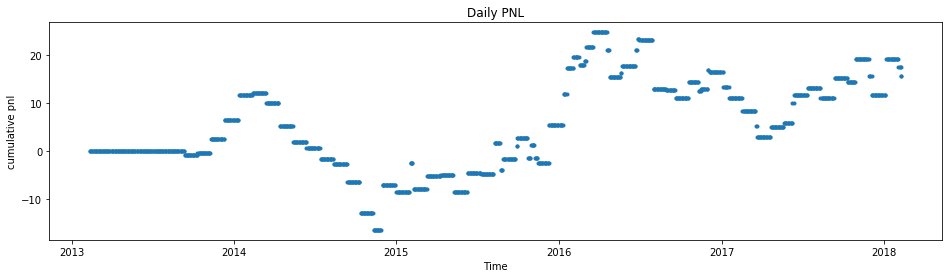

In [38]:
# convert string to datetime
df["datetime"] = df["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))

# plot PNL figures 
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['cumulative_pnl'] ,'.') 
plt.xlabel("Time")
plt.ylabel("cumulative pnl")
plt.title("Daily PNL")
plt.show()